# Natural Language Processing with Disaster Tweets

Importing all packages

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Reading data from files (test and train)

In [296]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

Example data

In [297]:
df_train



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [298]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Number of all records

In [299]:
df_train['id'].count()

7613

Count and graph of non-disaster/disaster tweets

In [300]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

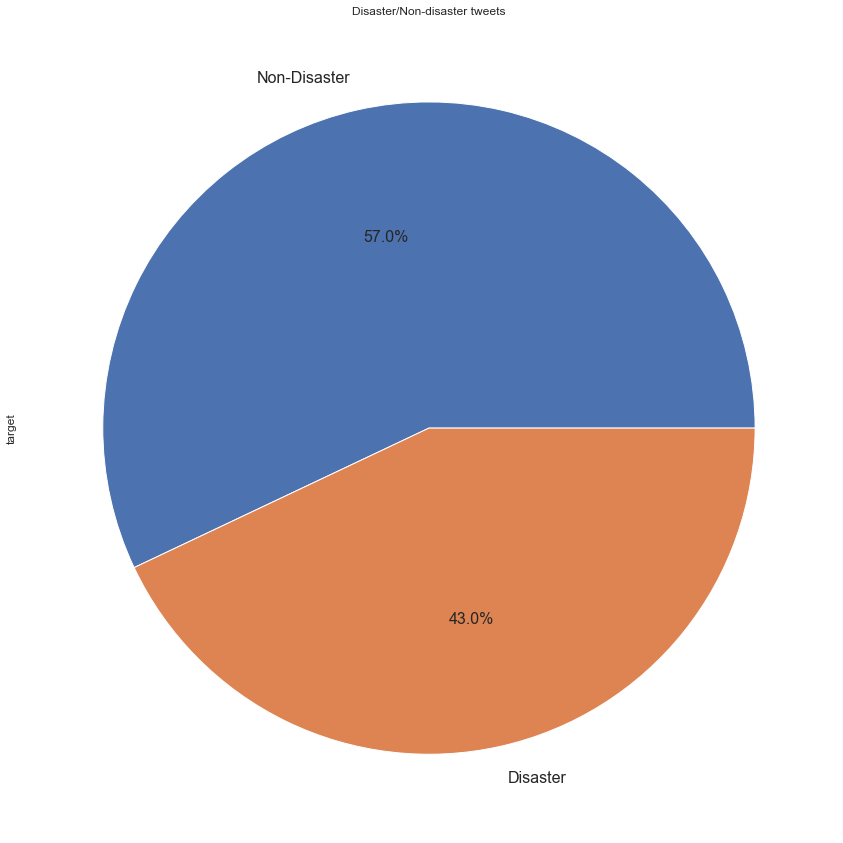

In [301]:
df_train['target'].value_counts().plot(kind='pie',
                                         title='Disaster/Non-disaster tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         labels=['Non-Disaster', 'Disaster'],
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

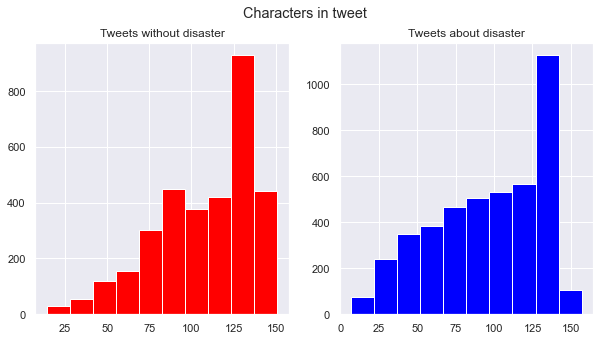

In [302]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize = (10,5))
disaster_tweets_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(disaster_tweets_len, color = 'red')
ax1.set_title('Tweets without disaster')

notdisaster_tweets_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(notdisaster_tweets_len, color = 'blue')
ax2.set_title('Tweets about disaster')

fig.suptitle('Characters in tweet')
plt.show()

List of the most occurring words in keyboard (general)

In [303]:
df_train.keyword.value_counts().sort_values(ascending=False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

List of the most occurring words in keyboard (only in disaster tweets)

In [304]:
df_train_true_key = df_train[df_train['target'] == 1].keyword.value_counts().sort_values(ascending=False)
df_train_true_key

derailment     39
outbreak       39
wreckage       39
debris         37
typhoon        37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

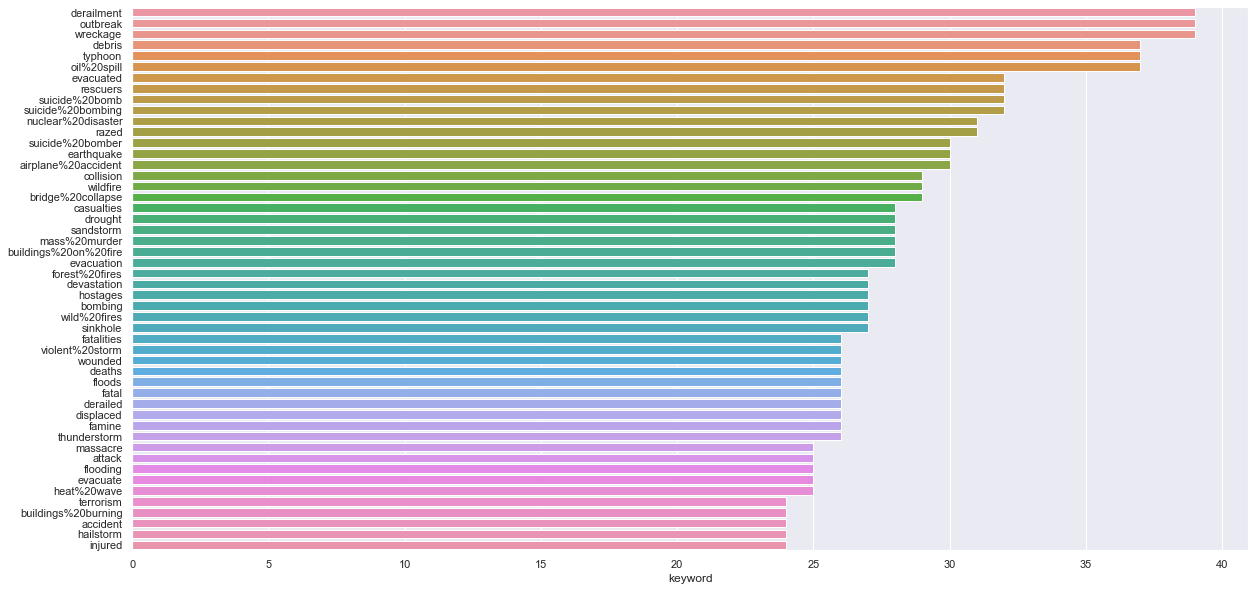

In [305]:
sns.barplot(y = df_train_true_key.index[:50], x = df_train_true_key[:50])
sns.set(rc={'figure.figsize':(20, 10)})

# Cleaning data



Change all text to lower case

In [306]:
df_train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [307]:

def lowerText(text):
    text = text.lower()
    return text

df_train['text'] = df_train['text'].apply(lambda x : lowerText(x))

df_train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

Remove ASCII spaces and ampersands

In [308]:
def removeAscii(text):
    rem = re.compile(r'%20')
    return rem.sub(r'', text)

def changeAnd(text):
    ch = re.compile(r'&amp;')
    return ch.sub(r'and', text)

df_train['text'] = df_train['text'].apply(lambda x : removeAscii(x))
df_train['text'] = df_train['text'].apply(lambda x : changeAnd(x))

Remove links

In [309]:
ex = df_train.iloc[40,3]
ex

'check these out: http://t.co/roi2nsmejj http://t.co/3tj8zjin21 http://t.co/yduixefipe http://t.co/lxtjc87kls #nsfw'

In [310]:
def deleteLinks(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [311]:
df_train['text'] = df_train['text'].apply(lambda sentence: deleteLinks(sentence))

In [312]:
ex = df_train.iloc[40,3]
ex

'check these out:     #nsfw'

Change acronyms to normal words

In [313]:
ex2 = df_train.iloc[280,3]
ex2

"but if it's the apocalypse lol gf m8"

In [314]:
acronyms = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def removeAcronyms(text):
    newtext = ""
    for word in text.split():
        w = acronyms[word.lower()] if word.lower() in acronyms.keys() else word
        newtext += w + " "
    return newtext

df_train['text'] = df_train['text'].apply(lambda x : removeAcronyms(x))

In [315]:
ex2 = df_train.iloc[280,3]
ex2

"but if it's the apocalypse laughing out loud gf mate "

Delete all stop words

In [316]:
stopWords = nltk.corpus.stopwords.words('english')
df_train.iloc[2000,3]

'@bradleybrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough '

In [317]:
def removeStopWords(text):
    return ' '.join([word for word in text.split() if word not in (stopWords)])
    
df_train['text'] = df_train['text'].apply(lambda x : removeStopWords(x))
df_train.iloc[2000,3]

'@bradleybrad47 saw fast af great damage upgraded shitton used exclusively whole playthrough'

In [318]:
def cleanData(text):
    text = lowerText(text)
    text = removeAscii(text)
    text = changeAnd(text)
    text = deleteLinks(text)
    text = removeAcronyms(text)
    text = removeStopWords(text)
    return text

#df_test['text'] = df_test['text'].apply(lambda x : cleanData(x))
#df_test

# Tokenization

In [319]:
df_train_regexToken = df_train.copy()
df_train_treebankToken = df_train.copy()
df_train_lemma = df_train.copy()

In [320]:
tokenizator = nltk.tokenize.RegexpTokenizer(r'\w+')
df_train_regexToken['text'] = df_train_regexToken['text'].apply(lambda x:tokenizator.tokenize(x))
df_train_regexToken.head()


,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[13, 000, people, receive, wildfires, evacuati...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [321]:

def treeBankTokenizer(text):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()

    return tokenizer.tokenize(text)



df_train_treebankToken['text'] = df_train_treebankToken['text'].apply(lambda x: treeBankTokenizer(str(x)))
df_train_treebankToken.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, #, earthquake, may, allah, for...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask., canada]",1
2,5,NaN,NaN,"[residents, asked, 'shelter, place, ', notifie...",1
3,6,NaN,NaN,"[13,000, people, receive, #, wildfires, evacua...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, #, alaska, smoke, #, ...",1


# Steemer


In [322]:
def stemList(listOwN):
    res = [steemer(i) for i in listOwN]
    return res


def steemer(text):
    st = nltk.stem.PorterStemmer()
    ret = st.stem(text)
    return ret


# on regex tokenization
df_train_regexToken['text'] = df_train_regexToken['text'].apply(lambda x: stemList(x))
df_train_regexToken.head()


,id,keyword,location,text,target
0,1,NaN,NaN,"[deed, reason, earthquak, may, allah, forgiv, us]",1
1,4,NaN,NaN,"[forest, fire, near, la, rong, sask, canada]",1
2,5,NaN,NaN,"[resid, ask, shelter, place, notifi, offic, ev...",1
3,6,NaN,NaN,"[13, 000, peopl, receiv, wildfir, evacu, order...",1
4,7,NaN,NaN,"[got, sent, photo, rubi, alaska, smoke, wildfi...",1


In [323]:
# on treebank tokenization

df_train_treebankToken['text'] = df_train_treebankToken['text'].apply(lambda x: stemList(x))
df_train_treebankToken.head()


,id,keyword,location,text,target
0,1,NaN,NaN,"[deed, reason, #, earthquak, may, allah, forgi...",1
1,4,NaN,NaN,"[forest, fire, near, la, rong, sask., canada]",1
2,5,NaN,NaN,"[resid, ask, 'shelter, place, ', notifi, offic...",1
3,6,NaN,NaN,"[13,000, peopl, receiv, #, wildfir, evacu, ord...",1
4,7,NaN,NaN,"[got, sent, photo, rubi, #, alaska, smoke, #, ...",1


# Lemmatization

In [324]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def lemmaList(listOwN):
    tokens = listOwN.split() 
    tagged = nltk.pos_tag(tokens)
    res = [lemmatizer(i) for i in tagged]
    return res


def lemmatizer(tagged):
    l = nltk.WordNetLemmatizer()
    tag = nltk.pos_tag(tagged)
    for word , tag in tag:
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            return l.lemmatize(word)
        else:
            return l.lemmatize(word,pos=wntag) 


df_train_lemma['text'] = df_train_lemma['text'].apply(lambda x: lemmaList(x))
df_train_lemma.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deed, reason, #earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask., canada]",1
2,5,NaN,NaN,"[resident, ask, 'shelter, place', notify, offi...",1
3,6,NaN,NaN,"[13,000, people, receive, #wildfires, evacuati...",1
4,7,NaN,NaN,"[get, sent, photo, ruby, #alaska, smoke, #wild...",1


# Combining text back

In [325]:
def combine_text_list(list):
    combined = ' '.join(list)
    return combined


df_train_regexToken['text'] = df_train_regexToken['text'].apply(lambda x : combine_text_list(x))
df_train_lemma['text'] = df_train_lemma['text'].apply(lambda x : combine_text_list(x))
df_train_treebankToken['text'] = df_train_treebankToken['text'].apply(lambda x : combine_text_list(x))
df_train_regexToken.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,13 000 peopl receiv wildfir evacu order califo...,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


# split data

In [326]:


owntrain,owntest = train_test_split(df_train,test_size=0.4,random_state=20)
test_x,test_y = owntest['text'],owntest['target']
train_x,train_y = owntrain['text'],owntrain['target']


owntrain_regex,owntest_regex = train_test_split(df_train_regexToken,test_size=0.33,random_state=20)
test_x_regextoken,test_y_regextoken = owntest_regex['text'],owntest_regex['target']
train_x_regextoken,train_y_regextoken = owntrain_regex['text'],owntrain_regex['target']


owntrain_treebanktoken,owntest_treebanktoken = train_test_split(df_train_treebankToken,test_size=0.33,random_state=20)
train_x_treebanktoken,train_y_treebanktoken = owntrain_treebanktoken['text'],owntrain_treebanktoken['target']
test_x_treebanktoken,test_y_treebanktoken = owntest_treebanktoken['text'],owntest_treebanktoken['target']


owntrain_lemma,owntest_lemma = train_test_split(df_train_lemma,test_size=0.33,random_state=20)
train_x_lemma,train_y_lemma = owntrain_lemma['text'],owntrain_lemma['target']
test_x_lemma,test_y_lemma = owntest_lemma['text'],owntest_lemma['target']





# Vectorization

In [327]:
count_vectorization = feature_extraction.text.CountVectorizer()
train_x_vector = count_vectorization.fit_transform(train_x)
count_vectorization2 = feature_extraction.text.CountVectorizer()
train_x_vector_regexToken = count_vectorization2.fit_transform(train_x_regextoken)
count_vectorization3 = feature_extraction.text.CountVectorizer()
train_x_vector_treebankToken = count_vectorization3.fit_transform(train_x_treebanktoken)
count_vectorization4 = feature_extraction.text.CountVectorizer()
train_x_vector_lemma = count_vectorization4.fit_transform(train_x_lemma)
train_x_vector

<4567x12296 sparse matrix of type '<class 'numpy.int64'>'
	with 42224 stored elements in Compressed Sparse Row format>

In [328]:
test_x_vector = count_vectorization.transform(test_x)
test_x_regex_vector = count_vectorization2.transform(test_x_regextoken)
test_x_treebanktoken_vector = count_vectorization3.transform(test_x_treebanktoken)
test_x_lemma_vector = count_vectorization4.transform(test_x_lemma)

# Model

In [329]:


def PrintRes(m_test_y,pred_y):
    accuracy = accuracy_score(m_test_y,pred_y)
    report = classification_report(pred_y, m_test_y)
    cm = confusion_matrix(m_test_y, pred_y)

    print("Classification report:")
    print("Accuracy: ", accuracy)
    print(report)

    sns.heatmap(cm, annot=True, fmt='g', cbar=False)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('MLP Confusion Matrix')
    plt.show()

    return accuracy

## Decision tree classifier

For "normal" data

In [330]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

dec_tree.score(test_x_vector,test_y)



0.752790544977019

Classification report:
Accuracy:  0.752790544977019
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1877
           1       0.66      0.73      0.69      1169

    accuracy                           0.75      3046
   macro avg       0.74      0.75      0.74      3046
weighted avg       0.76      0.75      0.75      3046



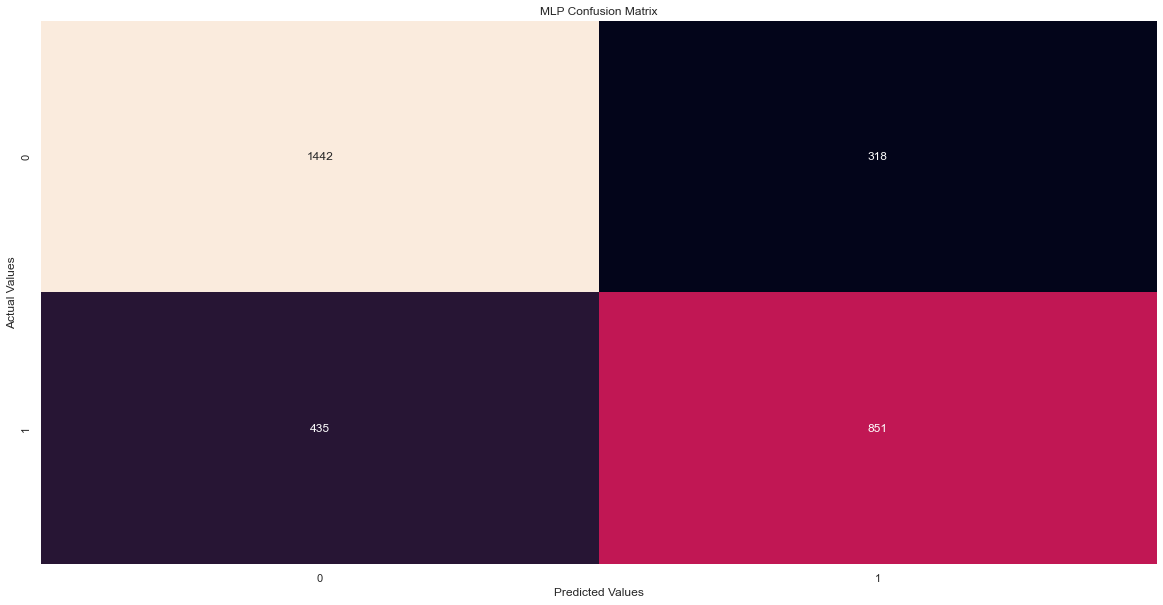

In [331]:
YPred = dec_tree.predict(test_x_vector)

dec_tree_acc = PrintRes(m_test_y=test_y,pred_y=YPred)


for regexToken with steeming data

In [332]:
dec_tree_regex = DecisionTreeClassifier()
dec_tree_regex.fit(train_x_vector_regexToken, train_y_regextoken)

dec_tree_regex.score(test_x_regex_vector,test_y_regextoken)


0.7461201750895344

Classification report:
Accuracy:  0.7461201750895344
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1537
           1       0.66      0.72      0.69       976

    accuracy                           0.75      2513
   macro avg       0.73      0.74      0.74      2513
weighted avg       0.75      0.75      0.75      2513



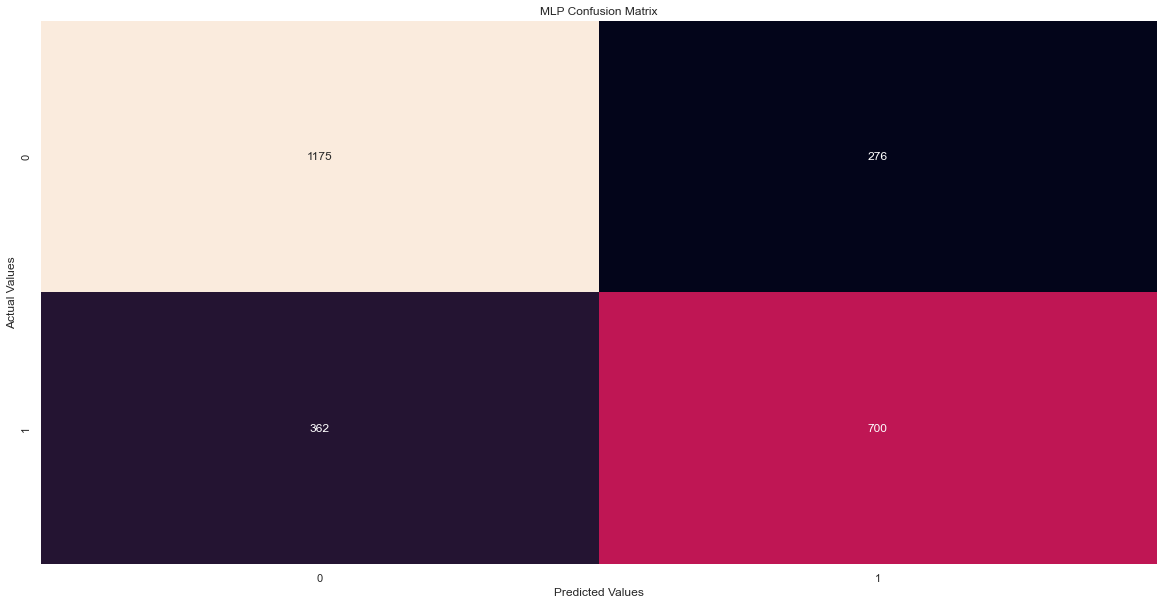

In [333]:
YPred = dec_tree_regex.predict(test_x_regex_vector)

dec_tree_acc_regex = PrintRes(m_test_y=test_y_regextoken,pred_y=YPred)

for TreeBankToken with steeming data

In [334]:
dec_tree_treeBank = DecisionTreeClassifier()
dec_tree_treeBank.fit(train_x_vector_treebankToken, train_y_treebanktoken)

dec_tree_treeBank.score(test_x_treebanktoken_vector,test_y_treebanktoken)

0.756466374850776

Classification report:
Accuracy:  0.756466374850776
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1519
           1       0.68      0.73      0.70       994

    accuracy                           0.76      2513
   macro avg       0.75      0.75      0.75      2513
weighted avg       0.76      0.76      0.76      2513



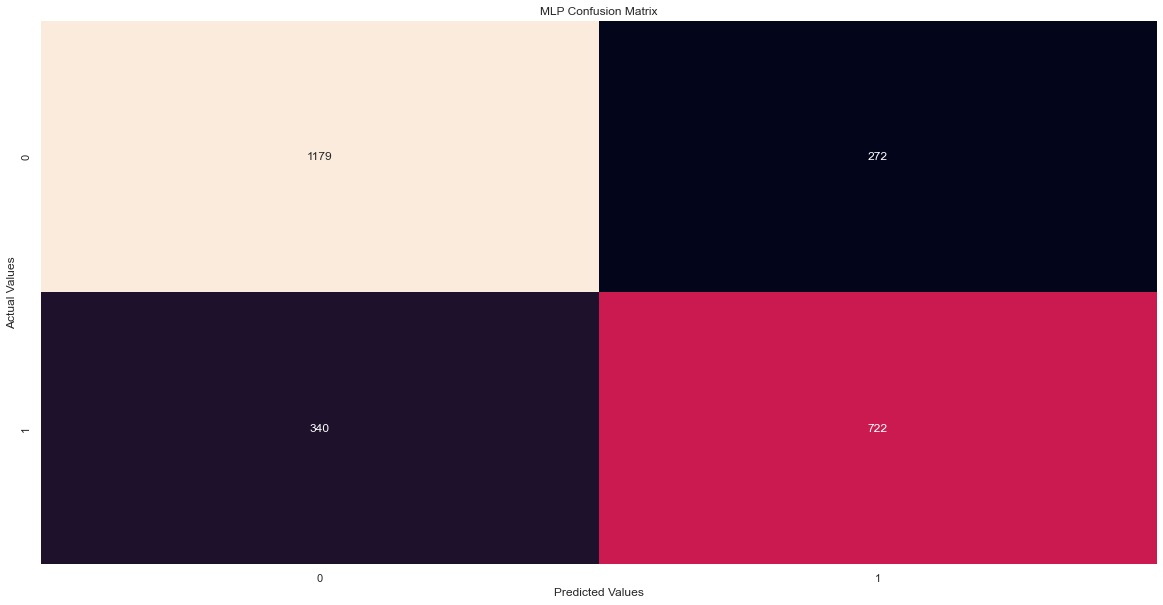

In [335]:
YPred = dec_tree_treeBank.predict(test_x_treebanktoken_vector)

dec_tree_acc_treeBank = PrintRes(m_test_y=test_y_treebanktoken,pred_y=YPred)

For lemmatization

In [336]:
dec_tree_lemma = DecisionTreeClassifier()
dec_tree_lemma.fit(train_x_vector_lemma, train_y_lemma)

dec_tree_lemma.score(test_x_lemma_vector,test_y_lemma)

0.754874651810585

Classification report:
Accuracy:  0.754874651810585
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1555
           1       0.66      0.73      0.70       958

    accuracy                           0.75      2513
   macro avg       0.74      0.75      0.75      2513
weighted avg       0.76      0.75      0.76      2513



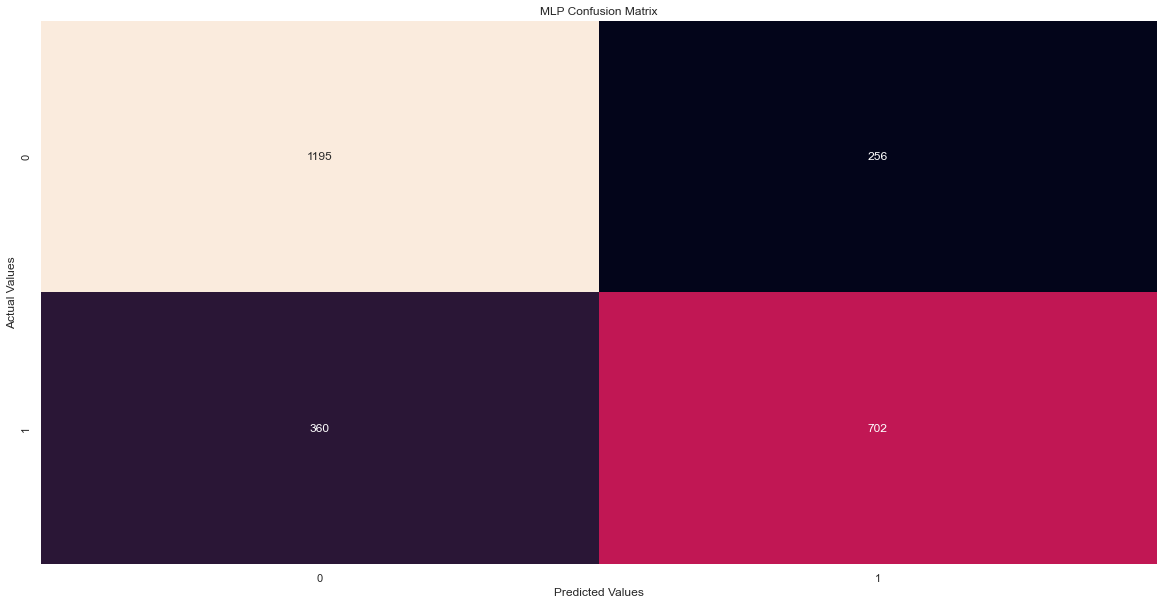

In [337]:
YPred = dec_tree_lemma.predict(test_x_lemma_vector)

dec_tree_acc_lemma = PrintRes(m_test_y=test_y_lemma,pred_y=YPred)

comparison

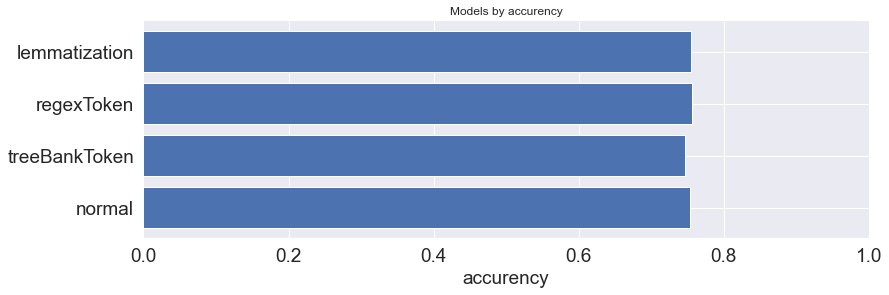

In [338]:
vals = {dec_tree_acc,dec_tree_acc_regex,dec_tree_acc_treeBank,dec_tree_acc_lemma}
models_Values = list(vals)
mod = {'normal','regexToken','treeBankToken','lemmatization'}
mod_list = list(mod)


def compareGraph(mod,val):

    plt.figure(figsize=(13,4))
    plt.barh(mod,val)
    plt.xlim(0,1)
    plt.title('Models by accurency')
    plt.xlabel('accurency',fontsize=19)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.tick_params(left=False)
    sns.despine(left=True)
    plt.show()


compareGraph(mod_list,models_Values)


## Naive Bayes Bernoulli classifier 

For "normal" data

In [339]:
ber = BernoulliNB()
ber.fit(train_x_vector.toarray(),train_y)

ber.score(test_x_vector,test_y)

0.804333552199606

Classification report:
Accuracy:  0.804333552199606
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      2112
           1       0.63      0.87      0.73       934

    accuracy                           0.80      3046
   macro avg       0.78      0.82      0.79      3046
weighted avg       0.84      0.80      0.81      3046



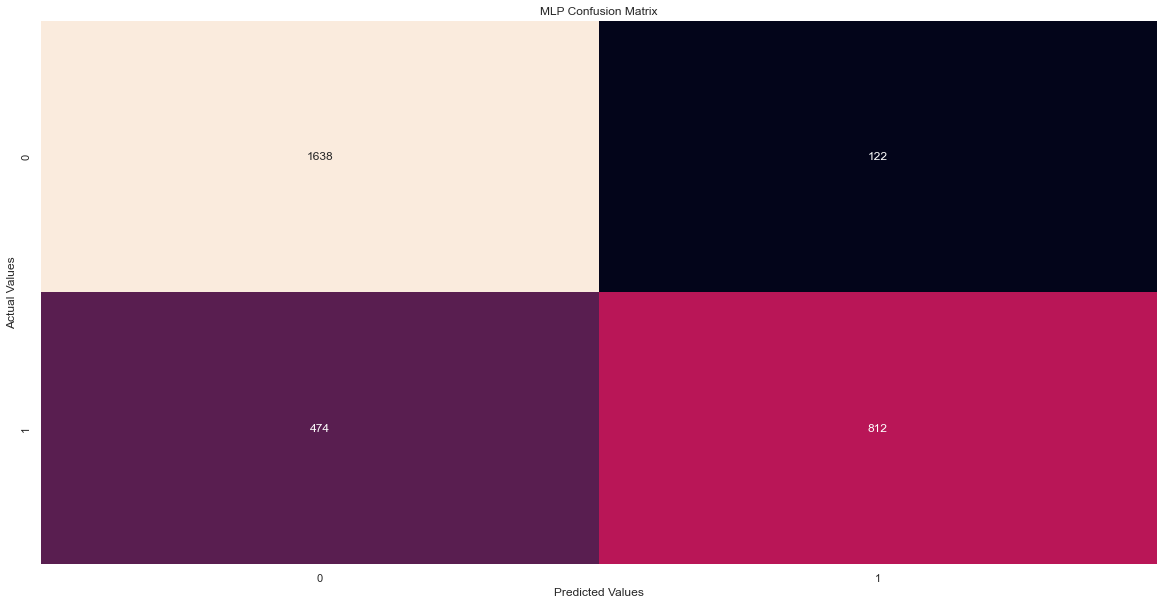

In [340]:
YPred = ber.predict(test_x_vector)

ber_acc=PrintRes(m_test_y=test_y,pred_y=YPred)


for regexToken with steeming data

In [341]:
ber_regex = BernoulliNB()
ber_regex.fit(train_x_vector_regexToken.toarray(),train_y_regextoken)

ber_regex.score(test_x_regex_vector,test_y_regextoken)

0.8141663350577

Classification report:
Accuracy:  0.8141663350577
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1686
           1       0.67      0.86      0.75       827

    accuracy                           0.81      2513
   macro avg       0.79      0.83      0.80      2513
weighted avg       0.84      0.81      0.82      2513



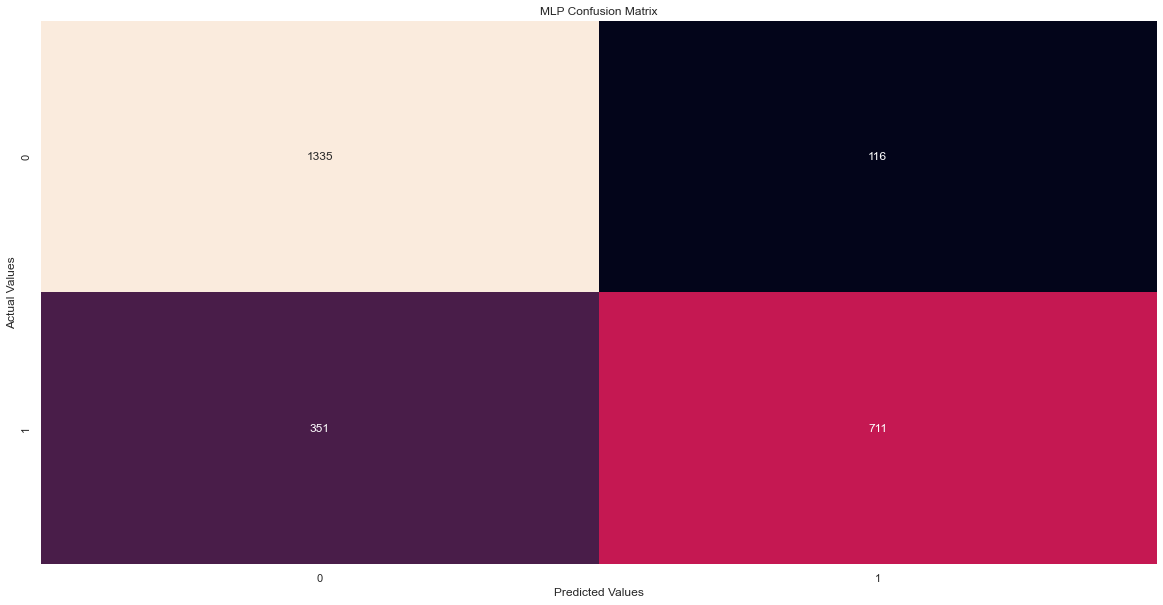

In [342]:
YPred = ber_regex.predict(test_x_regex_vector)

ber_acc_regec=PrintRes(m_test_y=test_y_regextoken,pred_y=YPred)

for TreeBankToken with steeming data

In [343]:
ber_treeBank = BernoulliNB()
ber_treeBank.fit(train_x_vector_treebankToken.toarray(),train_y_treebanktoken)

ber_treeBank.score(test_x_treebanktoken_vector,test_y_treebanktoken)

0.8125746120175089

Classification report:
Accuracy:  0.8125746120175089
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1686
           1       0.67      0.86      0.75       827

    accuracy                           0.81      2513
   macro avg       0.79      0.82      0.80      2513
weighted avg       0.84      0.81      0.82      2513



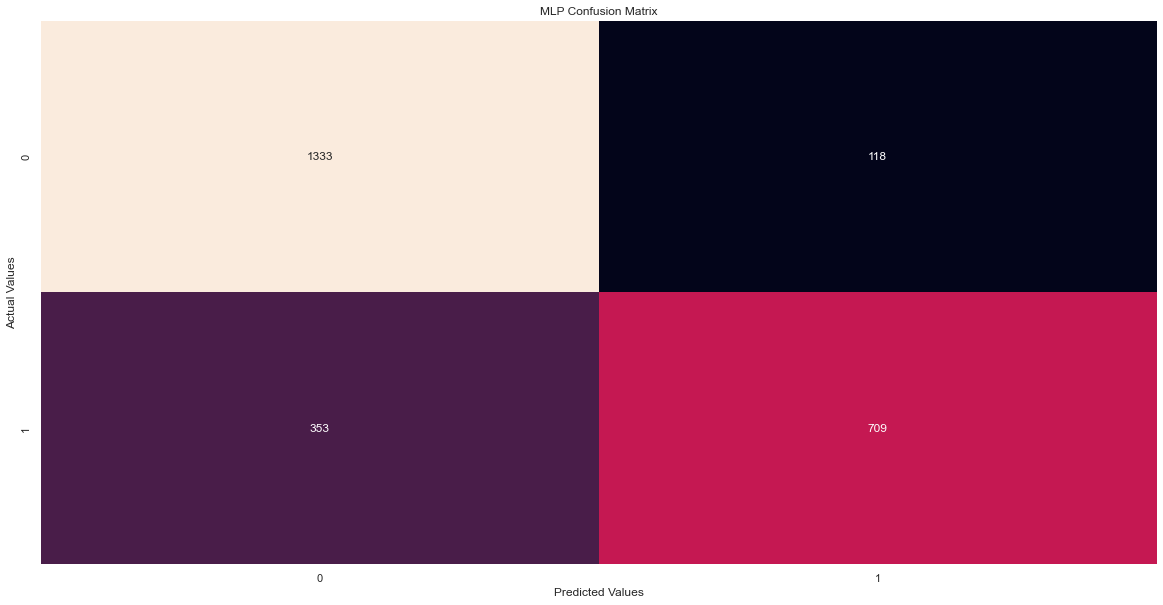

In [344]:
YPred = ber_treeBank.predict(test_x_treebanktoken_vector)

ber_acc_treeBank=PrintRes(m_test_y=test_y_treebanktoken,pred_y=YPred)

For lemmatization

In [345]:
ber_lemma = BernoulliNB()
ber_lemma.fit(train_x_vector_lemma.toarray(),train_y_lemma)

ber_lemma.score(test_x_lemma_vector,test_y_lemma)

0.8093911659371269

Classification report:
Accuracy:  0.8093911659371269
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1700
           1       0.66      0.86      0.74       813

    accuracy                           0.81      2513
   macro avg       0.79      0.82      0.80      2513
weighted avg       0.84      0.81      0.81      2513



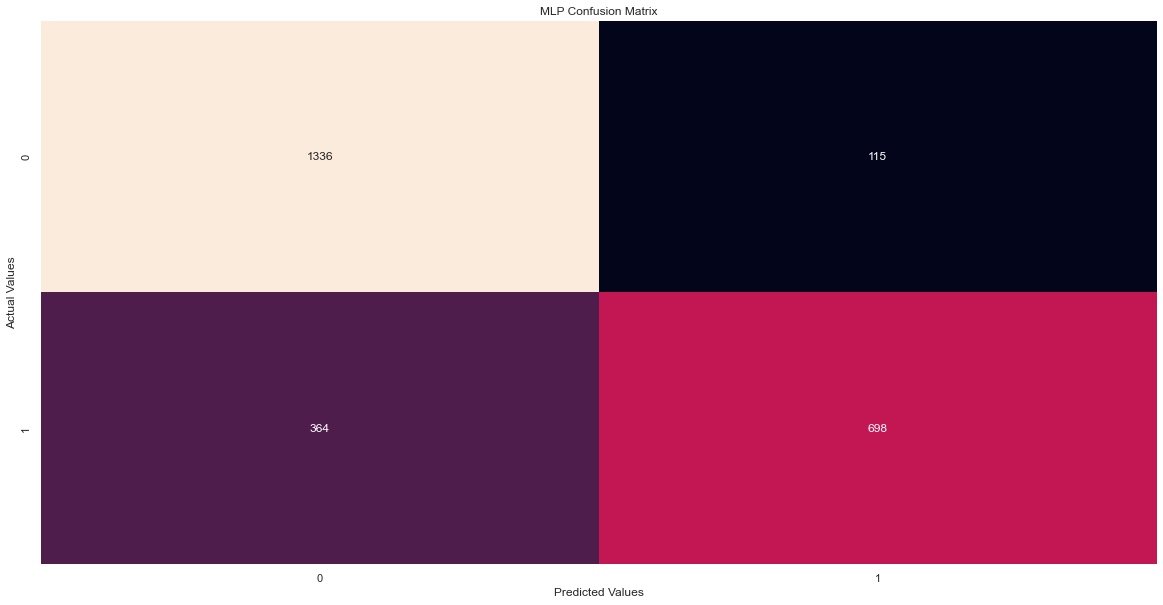

In [346]:
YPred = ber_lemma.predict(test_x_lemma_vector)

ber_acc_lemma=PrintRes(m_test_y=test_y_lemma,pred_y=YPred)

compare

In [347]:
p = {ber_acc,ber_acc_regec,ber_acc_treeBank,ber_acc_lemma}
k = list(p)
m = {'normal','regexToken','treeBankToken','regexToken with lemmatization'}
j = list(m)

#compareGraph(j,k)

## Naive Bayes classifier  (Multinomial) 

For "normal" data

In [348]:
mul = MultinomialNB()
mul.fit(train_x_vector.toarray(),train_y)

mul.score(test_x_vector,test_y)

0.7971109652002626

Classification report:
Accuracy:  0.7971109652002626
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1850
           1       0.72      0.78      0.75      1196

    accuracy                           0.80      3046
   macro avg       0.79      0.79      0.79      3046
weighted avg       0.80      0.80      0.80      3046



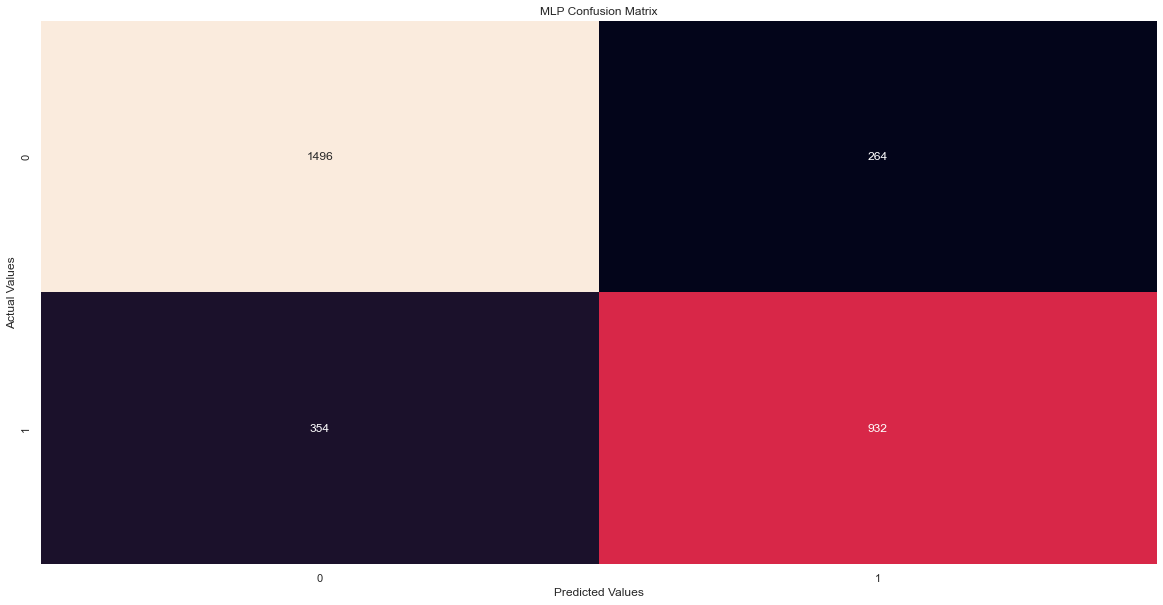

In [349]:
YPred = mul.predict(test_x_vector)

mul_acc=PrintRes(m_test_y=test_y,pred_y=YPred)

for regexToken with steeming data

In [350]:
mul_regex = MultinomialNB()
mul_regex.fit(train_x_vector_regexToken.toarray(),train_y_regextoken)

mul_regex.score(test_x_regex_vector,test_y_regextoken)

0.8097890966971747

Classification report:
Accuracy:  0.8097890966971747
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1541
           1       0.73      0.80      0.76       972

    accuracy                           0.81      2513
   macro avg       0.80      0.81      0.80      2513
weighted avg       0.81      0.81      0.81      2513



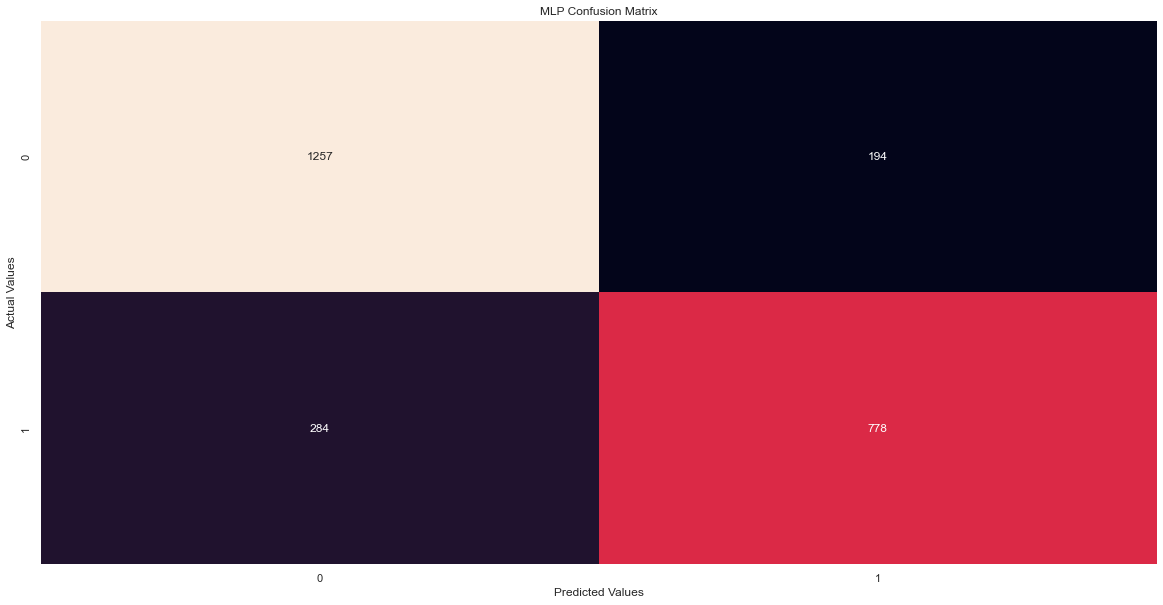

In [351]:
YPred = mul_regex.predict(test_x_regex_vector)

mul_regex_acc=PrintRes(m_test_y=test_y_regextoken,pred_y=YPred)

for TreeBankToken with steeming data

In [352]:
mul_treeBank = MultinomialNB()
mul_treeBank.fit(train_x_vector_treebankToken.toarray(),train_y_treebanktoken)

mul_treeBank.score(test_x_treebanktoken_vector,test_y_treebanktoken)

0.8074015121368882

Classification report:
Accuracy:  0.8074015121368882
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1541
           1       0.73      0.80      0.76       972

    accuracy                           0.81      2513
   macro avg       0.80      0.81      0.80      2513
weighted avg       0.81      0.81      0.81      2513



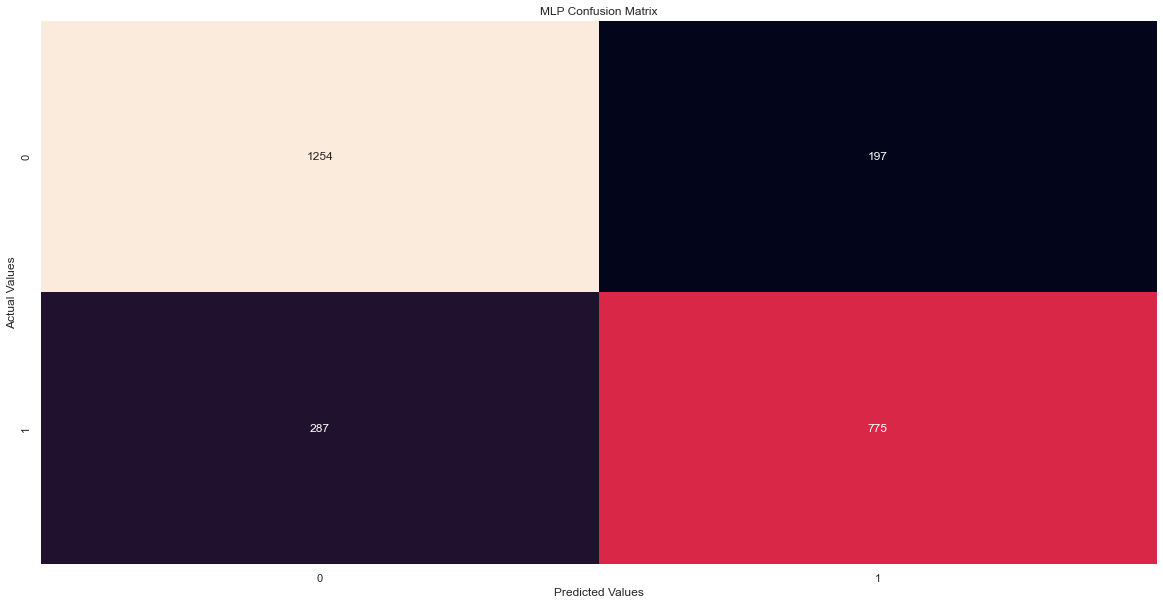

In [353]:
YPred = mul_treeBank.predict(test_x_treebanktoken_vector)

mul_treeBank__acc=PrintRes(m_test_y=test_y_treebanktoken,pred_y=YPred)

For lemmatization

In [354]:
mul_lemma = MultinomialNB()
mul_lemma.fit(train_x_vector_lemma.toarray(),train_y_lemma)

mul_lemma.score(test_x_lemma_vector,test_y_lemma)

0.8117787504974134

Classification report:
Accuracy:  0.8117787504974134
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1548
           1       0.73      0.81      0.77       965

    accuracy                           0.81      2513
   macro avg       0.80      0.81      0.80      2513
weighted avg       0.82      0.81      0.81      2513



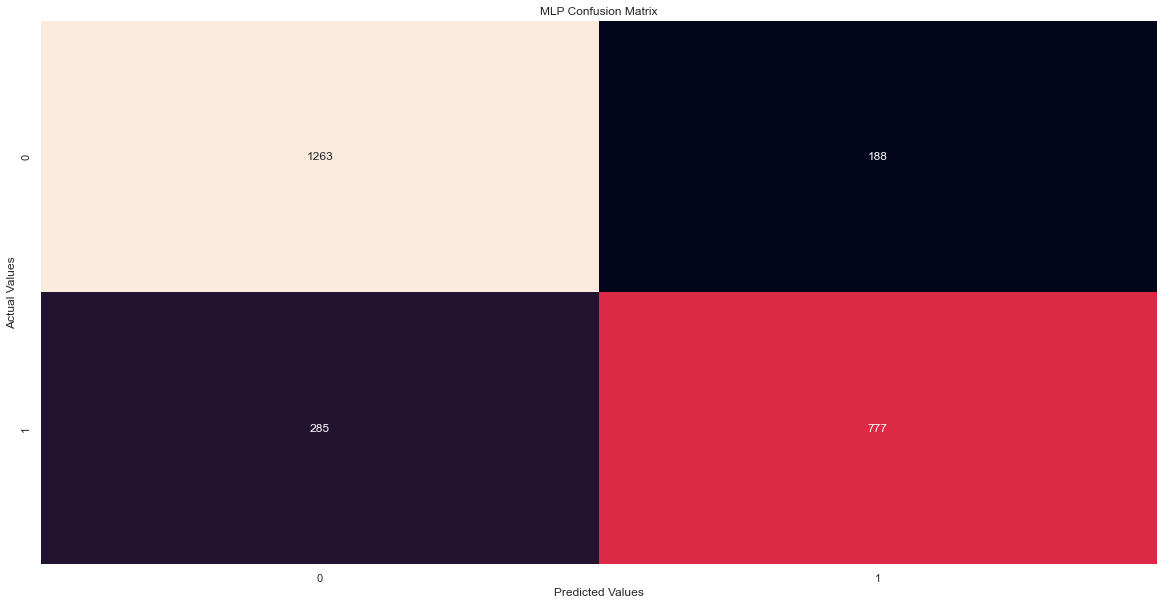

In [355]:
YPred = mul_lemma.predict(test_x_lemma_vector)

mul_lemma_acc=PrintRes(m_test_y=test_y_lemma,pred_y=YPred)

## Logistic regression classifier

For "normal" data

In [356]:
logReg = LogisticRegression()
logReg.fit(train_x_vector,train_y)

logReg.score(test_x_vector,test_y)

0.7994090610636901

Classification report:
Accuracy:  0.7994090610636901
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1931
           1       0.70      0.80      0.75      1115

    accuracy                           0.80      3046
   macro avg       0.79      0.80      0.79      3046
weighted avg       0.81      0.80      0.80      3046



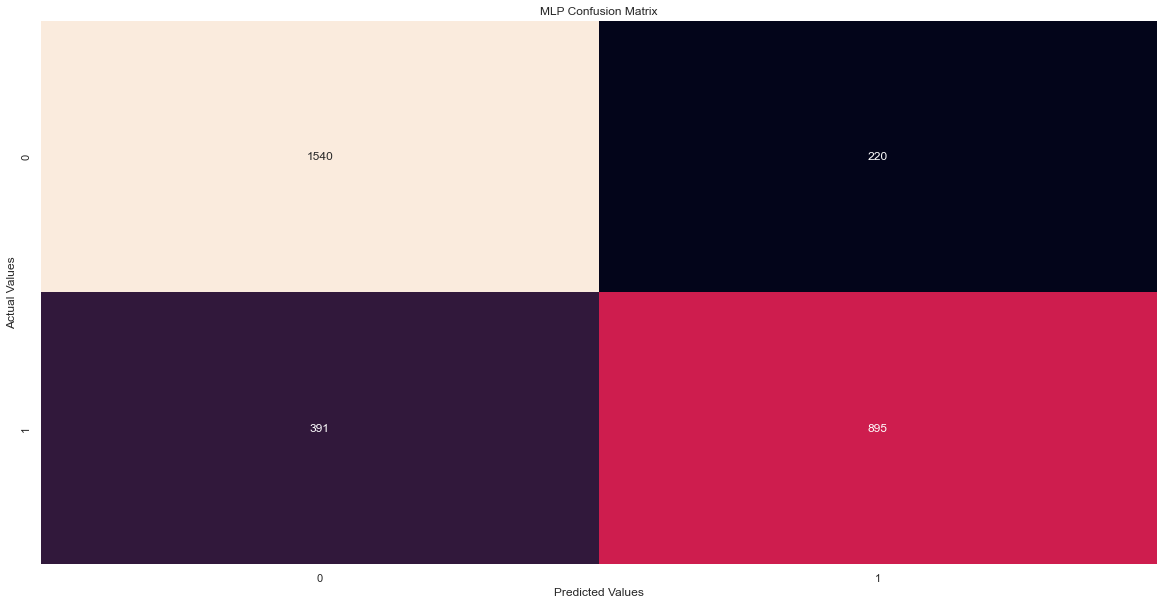

In [357]:
YPred = logReg.predict(test_x_vector)

logReg_acc = PrintRes(m_test_y=test_y,pred_y=YPred)

for regexToken with steeming data

In [358]:
logReg_regex = LogisticRegression()
logReg_regex.fit(train_x_vector_regexToken,train_y_regextoken)

logReg_regex.score(test_x_regex_vector,test_y_regextoken)

0.8070035813768405

Classification report:
Accuracy:  0.8070035813768405
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1572
           1       0.71      0.81      0.76       941

    accuracy                           0.81      2513
   macro avg       0.79      0.81      0.80      2513
weighted avg       0.81      0.81      0.81      2513



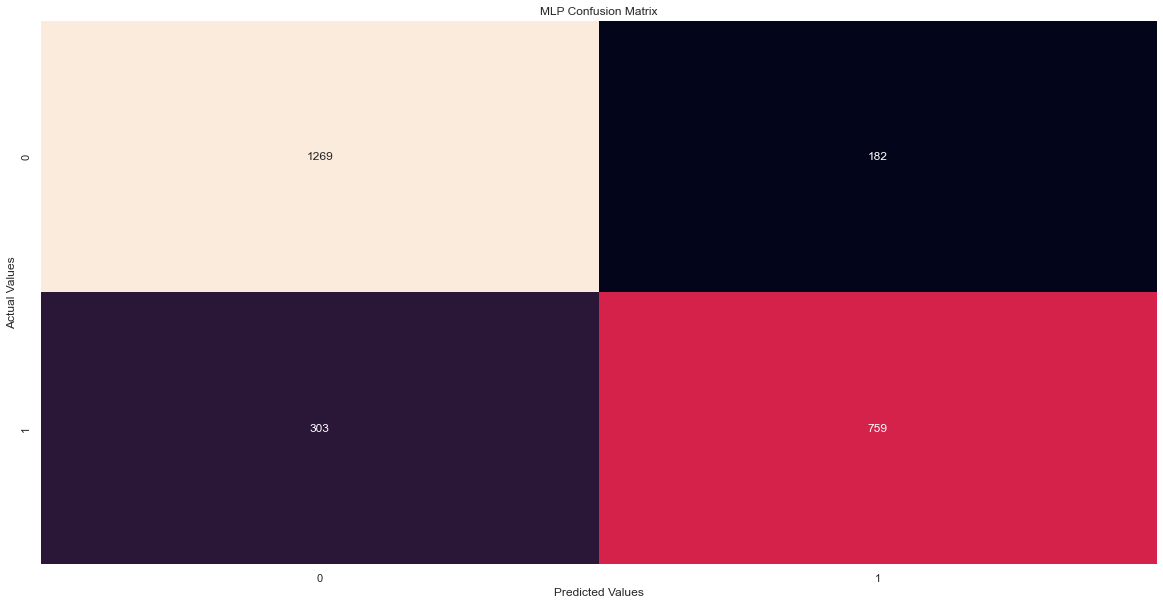

In [359]:
YPred = logReg_regex.predict(test_x_regex_vector)

logReg_acc_regex = PrintRes(m_test_y=test_y_regextoken,pred_y=YPred)

for TreeBankToken with steeming data

In [360]:
logReg_treeBank = LogisticRegression()
logReg_treeBank.fit(train_x_vector_treebankToken,train_y_treebanktoken)

logReg_treeBank.score(test_x_treebanktoken_vector,test_y_treebanktoken)

0.8058097890966972

Classification report:
Accuracy:  0.8058097890966972
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1585
           1       0.71      0.81      0.75       928

    accuracy                           0.81      2513
   macro avg       0.79      0.81      0.80      2513
weighted avg       0.81      0.81      0.81      2513



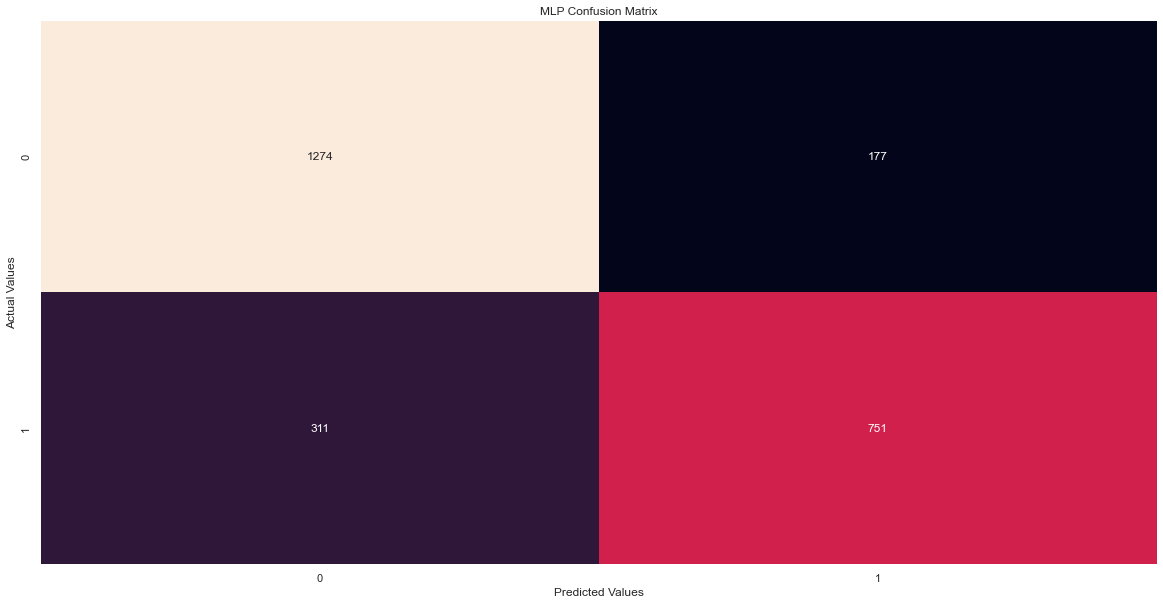

In [361]:
YPred = logReg_treeBank.predict(test_x_treebanktoken_vector)

logReg_acc_treeBank =PrintRes(m_test_y=test_y_treebanktoken,pred_y=YPred)

For lemmatization

In [362]:
logReg_lemma = LogisticRegression()
logReg_lemma.fit(train_x_vector_lemma,train_y_lemma)

logReg_lemma.score(test_x_lemma_vector,test_y_lemma)

0.8074015121368882

Classification report:
Accuracy:  0.8074015121368882
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1597
           1       0.70      0.82      0.76       916

    accuracy                           0.81      2513
   macro avg       0.79      0.81      0.80      2513
weighted avg       0.82      0.81      0.81      2513



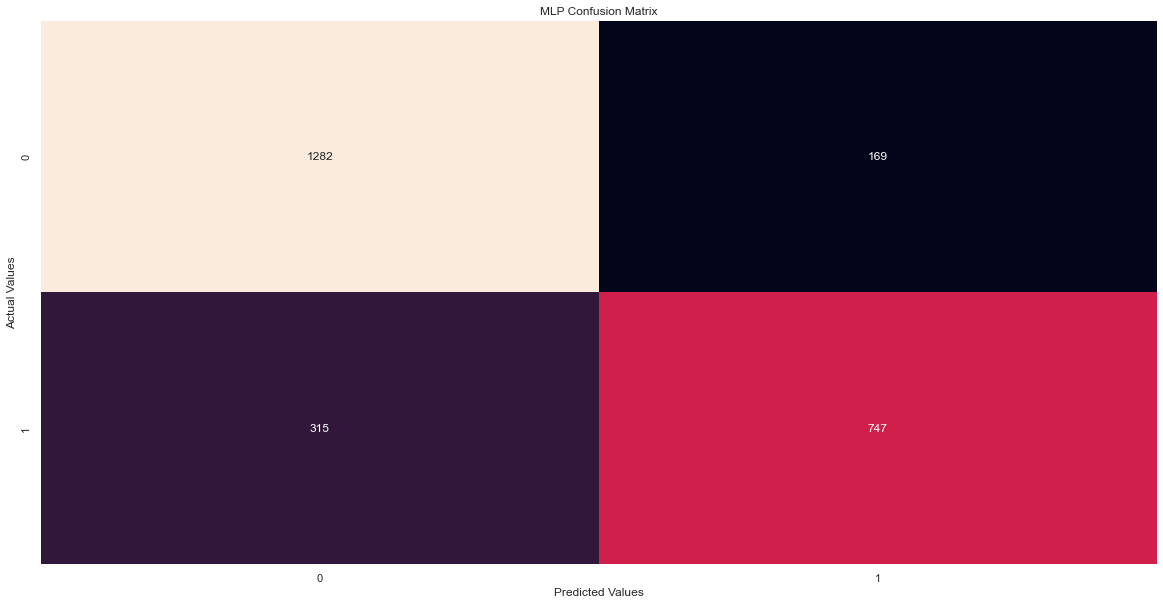

In [363]:
YPred = logReg_lemma.predict(test_x_lemma_vector)

logReg_acc_lemma =PrintRes(m_test_y=test_y_lemma,pred_y=YPred)

## Ridge regression classifier

For "normal" data

In [364]:
ridg = RidgeClassifier()
ridg.fit(train_x_vector,train_y)

ridg.score(test_x_vector,test_y)

0.7760998030203545

Classification report:
Accuracy:  0.7760998030203545
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1908
           1       0.68      0.77      0.72      1138

    accuracy                           0.78      3046
   macro avg       0.76      0.77      0.77      3046
weighted avg       0.78      0.78      0.78      3046



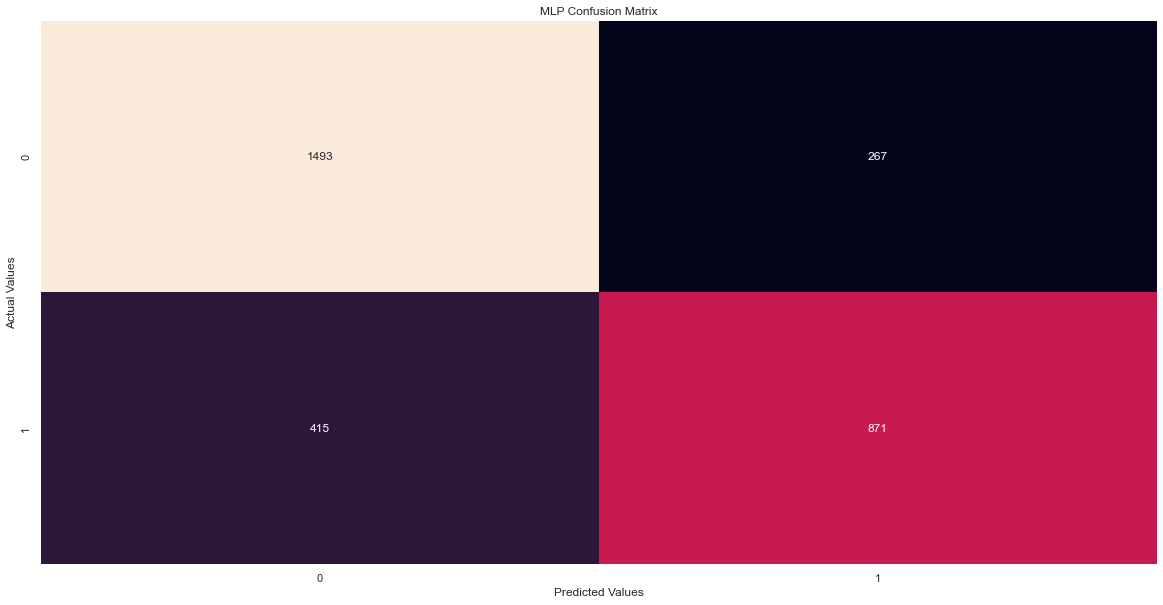

In [365]:
YPred = ridg.predict(test_x_vector)

ridg_acc = PrintRes(m_test_y=test_y,pred_y=YPred)

for regexToken with steeming data

In [366]:
ridg_regex = RidgeClassifier()
ridg_regex.fit(train_x_vector_regexToken,train_y_regextoken)

ridg_regex.score(test_x_regex_vector,test_y_regextoken)

0.781933943493832

Classification report:
Accuracy:  0.781933943493832
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1539
           1       0.70      0.76      0.73       974

    accuracy                           0.78      2513
   macro avg       0.77      0.78      0.77      2513
weighted avg       0.79      0.78      0.78      2513



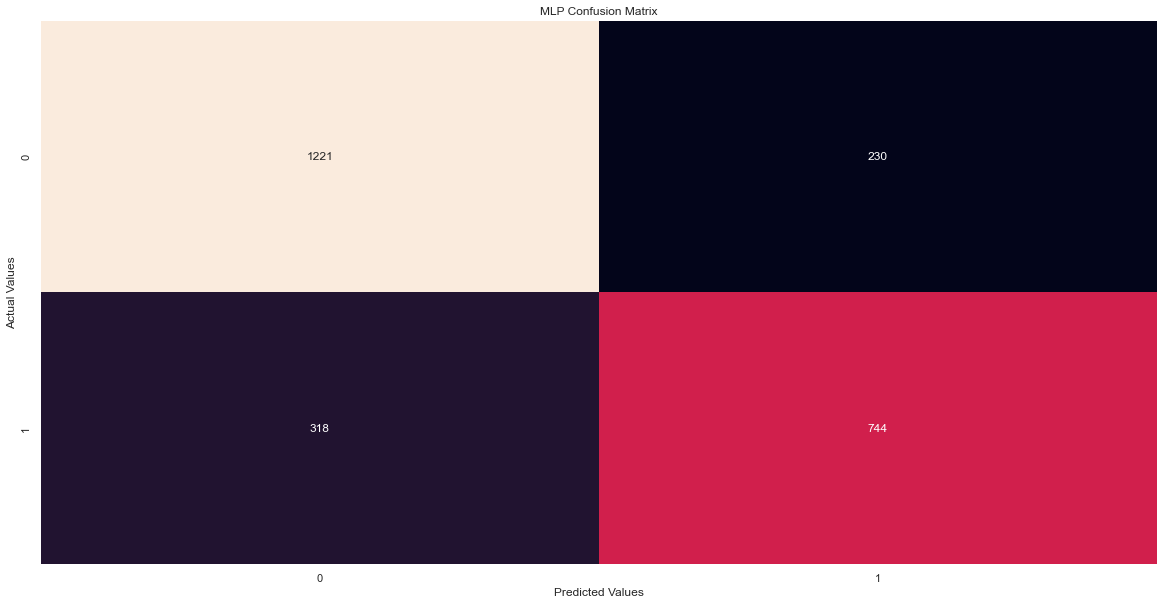

In [367]:
YPred = ridg_regex.predict(test_x_regex_vector)

ridg_acc_regex = PrintRes(m_test_y=test_y_regextoken,pred_y=YPred)

for TreeBankToken with steeming data

In [368]:
ridg_treeBank = RidgeClassifier()
ridg_treeBank.fit(train_x_vector_treebankToken,train_y_treebanktoken)

ridg_treeBank.score(test_x_treebanktoken_vector,test_y_treebanktoken)

0.7843215280541186

Classification report:
Accuracy:  0.7843215280541186
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1549
           1       0.70      0.77      0.73       964

    accuracy                           0.78      2513
   macro avg       0.77      0.78      0.78      2513
weighted avg       0.79      0.78      0.79      2513



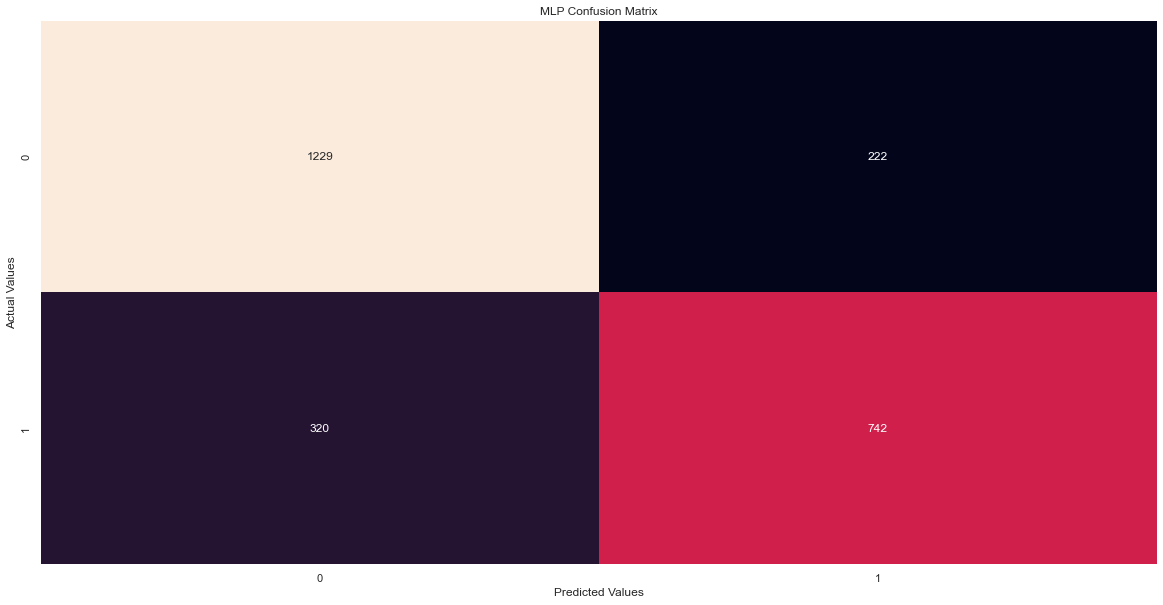

In [369]:
YPred = ridg_treeBank.predict(test_x_treebanktoken_vector)

ridg_acc_treeBank = PrintRes(m_test_y=test_y_treebanktoken,pred_y=YPred)

For lemmatization

In [370]:
ridg_lemma = RidgeClassifier()
ridg_lemma.fit(train_x_vector_lemma,train_y_lemma)

ridg_lemma.score(test_x_lemma_vector,test_y_lemma)

0.7855153203342619

Classification report:
Accuracy:  0.7855153203342619
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1556
           1       0.70      0.77      0.73       957

    accuracy                           0.79      2513
   macro avg       0.77      0.78      0.78      2513
weighted avg       0.79      0.79      0.79      2513



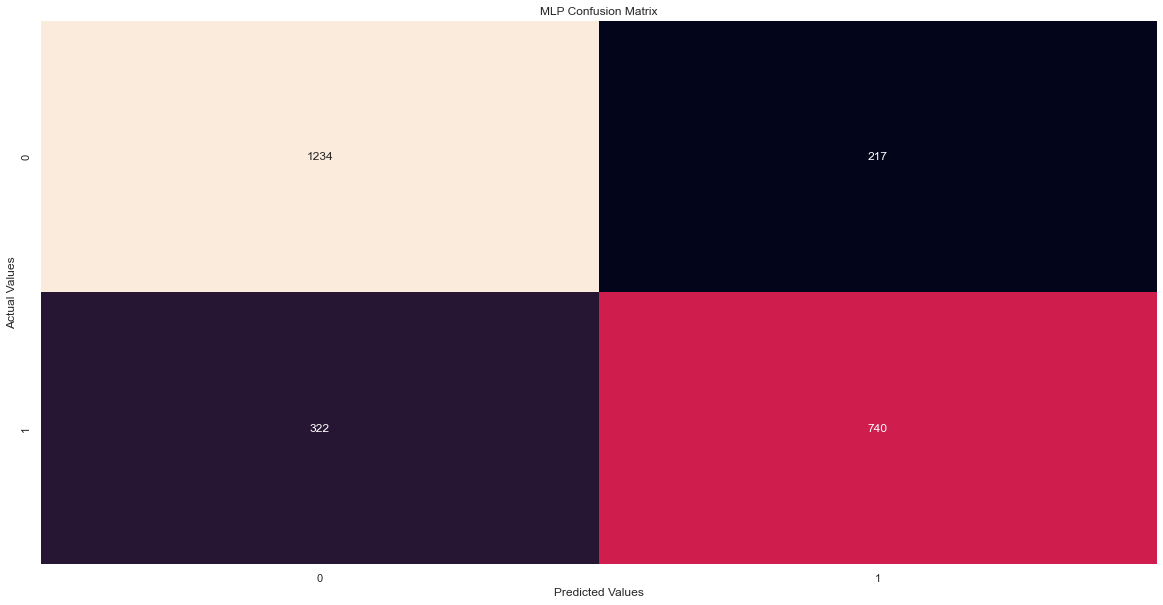

In [371]:
YPred = ridg_lemma.predict(test_x_lemma_vector)

ridg_acc_lemma = PrintRes(m_test_y=test_y_lemma,pred_y=YPred)

## Random forest classifier

In [293]:
rfc = RandomForestClassifier()
rfc.fit(train_x_vector.toarray(),train_y)

rfc.score(test_x_vector,test_y)

0.783650689428759

Classification report:
Accuracy:  0.7994090610636901
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1931
           1       0.70      0.80      0.75      1115

    accuracy                           0.80      3046
   macro avg       0.79      0.80      0.79      3046
weighted avg       0.81      0.80      0.80      3046



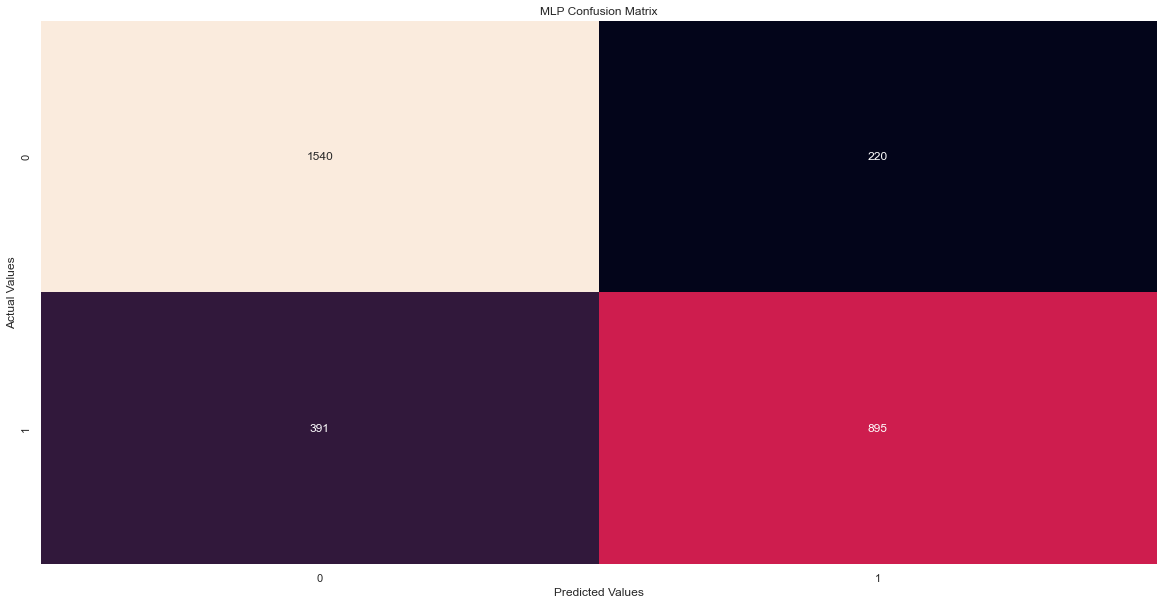

In [294]:
YPred = logReg.predict(test_x_vector)

rfc_acc =PrintRes(m_test_y=test_y,pred_y=YPred)